<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 6.68 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 16 09:22:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 174kB 54.8MB/s 
     |████████████████████████████████| 143kB 58.6MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: nz18lb5n
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/nz18lb5n


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 3pzefdyk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 29s 447ms/step - loss: 981390186.7094 - mean_squared_error: 981390186.7094 - mean_absolute_error: 4375.5241 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1630
Epoch 2/200
8/8 [==============================] - 1s 188ms/step - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1873 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - val_mean_absolute_error: 0.3353
Epoch 3/200
8/8 [==============================] - 1s 180ms/step - loss: 0.1010 - mean_squared_error: 0.1010 - mean_absolute_error: 0.2413 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1573
Epoch 4/200
8/8 [==============================] - 1s 179ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1551 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1147
Epoch 5/200
8/8 [==============================] - 2s 186ms/step - loss: 0.0325 

epoch,21
loss,0.00456
mean_squared_error,0.00456
mean_absolute_error,0.05219
val_loss,0.01799
val_mean_squared_error,0.01799
val_mean_absolute_error,0.10696
_runtime,69
_timestamp,1626368433
_step,21
best_val_loss,0.01547


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂█▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▃▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 8dwpnx4s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 10s 65ms/step - loss: 0.3065 - mean_squared_error: 0.3065 - mean_absolute_error: 0.2528 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1088
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0736 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1271
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0785 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1462
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0923 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.2072
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0175 - mean_squared_erro

epoch,49
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.03507
val_loss,0.00607
val_mean_squared_error,0.00607
val_mean_absolute_error,0.06013
_runtime,35
_timestamp,1626368484
_step,49
best_val_loss,0.00551


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▅█▃▂▃▂▂▂▂▂▂▃▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▄▅█▃▂▃▂▂▂▂▂▂▃▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▄▅█▄▃▄▃▂▂▃▂▂▄▃▃▂▂▂▃▂▂▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8gworvj6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 15s 249ms/step - loss: 0.1444 - mean_squared_error: 0.1444 - mean_absolute_error: 0.2902 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1046
Epoch 2/50
31/31 [==============================] - 6s 188ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0552 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1009
Epoch 3/50
31/31 [==============================] - 6s 195ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0428 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1054
Epoch 4/50
31/31 [==============================] - 6s 182ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0413 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1027
Epoch 5/50
31/31 [==============================] - 6s 179ms/step - loss: 0.0032 - mean_squared

epoch,49
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.0282
val_loss,0.01198
val_mean_squared_error,0.01198
val_mean_absolute_error,0.08958
_runtime,307
_timestamp,1626368805
_step,49
best_val_loss,0.01


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆█▇▅▅▄▆▅▄▄▄▄█▄▃▃▃▄▄▃▃▅▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▃
val_mean_squared_error,▇▆█▇▅▅▄▆▅▄▄▄▄█▄▃▃▃▄▄▃▃▅▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▃
val_mean_absolute_error,▇▆▇▆▆▅▅▆▅▄▄▄▅█▄▄▃▃▄▄▃▃▅▃▃▄▄▄▄▃▂▂▂▂▂▂▁▁▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zlkcdsps with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 14s 239ms/step - loss: 63.4827 - mean_squared_error: 63.4827 - mean_absolute_error: 0.9698 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1257
Epoch 2/100
31/31 [==============================] - 6s 191ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0692 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1145
Epoch 3/100
31/31 [==============================] - 6s 186ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0702 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1511
Epoch 4/100
31/31 [==============================] - 6s 187ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0584 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1195
Epoch 5/100
31/31 [==============================] - 6s 193ms/step - loss: 0.0060 - mean_

epoch,61
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03218
val_loss,0.00959
val_mean_squared_error,0.00959
val_mean_absolute_error,0.07822
_runtime,374
_timestamp,1626369216
_step,61
best_val_loss,0.00951


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▃▃█▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,▄▃▃▃█▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,▄▃▄▄█▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 47q1a984 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 66ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - mean_absolute_error: 0.1827 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1042
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0503 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0985
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0433 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0962
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0435 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0995
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error

epoch,49
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.02948
val_loss,0.00827
val_mean_squared_error,0.00827
val_mean_absolute_error,0.07191
_runtime,36
_timestamp,1626369264
_step,49
best_val_loss,0.00763


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▇█▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁
val_mean_squared_error,█▆▆▇█▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁
val_mean_absolute_error,█▇▆▇█▆▅▅▅▅▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fq83xbdi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 14s 247ms/step - loss: 0.1141 - mean_squared_error: 0.1141 - mean_absolute_error: 0.2448 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1063
Epoch 2/50
31/31 [==============================] - 6s 195ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0541 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1041
Epoch 3/50
31/31 [==============================] - 6s 192ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0562 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1054
Epoch 4/50
31/31 [==============================] - 6s 198ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0437 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1029
Epoch 5/50
31/31 [==============================] - 6s 195ms/step - loss: 0.0045 - mean_squared

epoch,49
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.03142
val_loss,0.01248
val_mean_squared_error,0.01248
val_mean_absolute_error,0.09118
_runtime,307
_timestamp,1626369582
_step,49
best_val_loss,0.01111


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▅▅▃▃▃▆▆▃▃▃▂▃▆▄▃█▃▂▃▂▂▃▃▃▂▂▁▂▁▂▂▁▂▁▂▁▁▂
val_mean_squared_error,▆▅▅▅▃▃▃▆▆▃▃▃▂▃▆▄▃█▃▂▃▂▂▃▃▃▂▂▁▂▁▂▂▁▂▁▂▁▁▂
val_mean_absolute_error,▆▅▅▅▄▄▄▆▆▄▃▄▃▃▆▄▃█▃▃▄▃▂▃▄▃▂▂▁▂▁▂▂▁▃▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t7dfv8fr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 8s 243ms/step - loss: 5.5856 - mean_squared_error: 5.5856 - mean_absolute_error: 1.2830 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1774
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1238 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1185
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1300 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1028
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0684 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1273
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0186 - mean_squared_error: 0.

epoch,16
loss,0.17022
mean_squared_error,0.17022
mean_absolute_error,0.2419
val_loss,0.03639
val_mean_squared_error,0.03639
val_mean_absolute_error,0.15741
_runtime,16
_timestamp,1626369610
_step,16
best_val_loss,0.01553


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
val_loss,▄▂▁▂▂▂▁██▂▂▄▅▃▂▁▃
val_mean_squared_error,▄▂▁▂▂▂▁██▂▂▄▅▃▂▁▃
val_mean_absolute_error,▅▂▁▂▃▂▁██▃▃▅▅▄▂▁▄
_runtime,▁▁▁▁▁▅▅▅▅▅▅██████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅██████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: sa2dt5dz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 244ms/step - loss: 0.1281 - mean_squared_error: 0.1281 - mean_absolute_error: 0.2758 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1165
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0763 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1091
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0598 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1120
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0961 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1228
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0081 - mean_squared_error: 0.

epoch,60
loss,0.00281
mean_squared_error,0.00281
mean_absolute_error,0.03898
val_loss,0.01323
val_mean_squared_error,0.01323
val_mean_absolute_error,0.09406
_runtime,22
_timestamp,1626369644
_step,60
best_val_loss,0.01103


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁
val_loss,▃▂▃█▂▃▂▂▂▃▂▂▃▂▂▂▁▁▁▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▃▂▃█▂▃▂▂▂▃▂▂▃▂▂▂▁▁▁▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▃▃▄█▃▃▂▂▂▃▂▃▃▂▂▂▂▂▂▃▂▂▁▂▂▂▃▁▂▁▁▁▁▁▂▂▁▁▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gp4rmiva with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 124ms/step - loss: 0.3816 - mean_squared_error: 0.3816 - mean_absolute_error: 0.3545 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1110
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0671 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1072
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0617 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1061
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0848 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1334
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0165 - mean_squared

epoch,92
loss,0.00201
mean_squared_error,0.00201
mean_absolute_error,0.03392
val_loss,0.00669
val_mean_squared_error,0.00669
val_mean_absolute_error,0.06759
_runtime,36
_timestamp,1626369699
_step,92
best_val_loss,0.00568


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▆▆▃▄▄▃▃▂█▂▃▂▂▃▂▃▂▄▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▂▂▁▁
val_mean_squared_error,▄▄▆▆▃▄▄▃▃▂█▂▃▂▂▃▂▃▂▄▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▂▂▁▁
val_mean_absolute_error,▅▅▆▆▄▄▅▃▄▃█▃▃▂▂▃▂▄▂▅▂▂▂▂▃▁▂▂▃▁▂▁▁▁▁▁▂▂▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: inrz1sm0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 8s 64ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - mean_absolute_error: 0.1649 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1058
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0563 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1070
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0512 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1097
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0516 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1028
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_

epoch,99
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02731
val_loss,0.00767
val_mean_squared_error,0.00767
val_mean_absolute_error,0.06882
_runtime,68
_timestamp,1626369793
_step,99
best_val_loss,0.00644


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▆█▄▅▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▃▁
val_mean_squared_error,▅▆█▄▅▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▃▁
val_mean_absolute_error,▆▇█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ei3k1dq4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 221ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - mean_absolute_error: 0.2698 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1158
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0746 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1115
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0602 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1424
Epoch 4/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1048 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1124
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.

epoch,169
loss,0.00178
mean_squared_error,0.00178
mean_absolute_error,0.03236
val_loss,0.00796
val_mean_squared_error,0.00796
val_mean_absolute_error,0.07245
_runtime,40
_timestamp,1626369847
_step,169
best_val_loss,0.00656


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅█▅▆▅▄▃▃▂▂▃▃▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,▅█▅▆▅▄▃▃▂▂▃▃▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,▇█▆▇▆▅▄▄▃▃▃▃▂▂▃▂▂▂▃▂▂▃▁▂▂▂▂▁▂▁▂▁▁▂▂▂▂▂▂▁
val_loss,▇▆███▆▄▅▅▆▄▃▃▃▃▄▅▄▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂
val_mean_squared_error,▇▆███▆▄▅▅▆▄▃▃▃▃▄▅▄▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂
val_mean_absolute_error,▇▇█▇▇▆▅▆▅▆▄▄▄▄▄▄▆▄▄▃▃▂▃▃▂▃▃▂▂▂▃▂▂▁▂▃▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pwfm5zpo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 10s 292ms/step - loss: 0.1651 - mean_squared_error: 0.1651 - mean_absolute_error: 0.3195 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1611
Epoch 2/200
16/16 [==============================] - 3s 179ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1241 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1065
Epoch 3/200
16/16 [==============================] - 3s 183ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0606 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1082
Epoch 4/200
16/16 [==============================] - 3s 180ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0477 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1072
Epoch 5/200
16/16 [==============================] - 3s 175ms/step - loss: 0.0041 - mean_sq

epoch,98
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.03038
val_loss,0.00921
val_mean_squared_error,0.00921
val_mean_absolute_error,0.07558
_runtime,313
_timestamp,1626370173
_step,98
best_val_loss,0.00846


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1nak552t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 111ms/step - loss: 0.1556 - mean_squared_error: 0.1556 - mean_absolute_error: 0.2982 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1298
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0934 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0976
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0942
Epoch 4/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0446 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0957
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_squared

epoch,102
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02575
val_loss,0.00563
val_mean_squared_error,0.00563
val_mean_absolute_error,0.05879
_runtime,40
_timestamp,1626370243
_step,102
best_val_loss,0.00554


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,█▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6nud9itm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 250ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - mean_absolute_error: 0.2888 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1326
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0778 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1103
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0628 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1099
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0476 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1101
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0029 - mean_squared_error: 0.0029 

epoch,49
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.03017
val_loss,0.01327
val_mean_squared_error,0.01327
val_mean_absolute_error,0.09314
_runtime,24
_timestamp,1626370295
_step,49
best_val_loss,0.01245


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▄▃▃▃▃▃▃▃▃▃▃▂▂▆▂▅▂▂▃▂▃▁▂▃▂▁▁▁▂▅▁▁▁▁▂▁
val_mean_squared_error,█▄▃▄▄▃▃▃▃▃▃▃▃▃▃▂▂▆▂▅▂▂▃▂▃▁▂▃▂▁▁▁▂▅▁▁▁▁▂▁
val_mean_absolute_error,█▄▄▄▄▄▄▄▃▃▃▄▃▃▃▃▂▆▂▅▂▂▃▂▃▂▂▃▂▂▁▁▂▅▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hhz2z1oe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 299ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - mean_absolute_error: 0.3169 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1824
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0653 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2013 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1767
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1032 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1062
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0579 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0970
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0039 - mean_squared_error: 0.

epoch,59
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.03767
val_loss,0.00899
val_mean_squared_error,0.00899
val_mean_absolute_error,0.07719
_runtime,25
_timestamp,1626370335
_step,59
best_val_loss,0.00844


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▁▂▂▂▁▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▂▂▂▃▂▂▂▂▂▃▁▁▂▂▃▁▂▃▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▃▁▁
val_mean_squared_error,██▂▂▂▃▂▂▂▂▂▃▁▁▂▂▃▁▂▃▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▃▁▁
val_mean_absolute_error,██▃▃▃▄▃▂▃▃▂▄▂▂▂▂▃▂▂▃▁▂▂▃▂▁▂▁▁▂▁▁▂▁▁▁▂▃▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vutoa2fl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 122ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - mean_absolute_error: 0.2034 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1093
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0541 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1070
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1026
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0363 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1017
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0023 - mean_squared

epoch,99
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.02095
val_loss,0.00487
val_mean_squared_error,0.00487
val_mean_absolute_error,0.05446
_runtime,42
_timestamp,1626370396
_step,99
best_val_loss,0.00475


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cfusrc1a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 11s 306ms/step - loss: 0.2013 - mean_squared_error: 0.2013 - mean_absolute_error: 0.3185 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1110
Epoch 2/200
16/16 [==============================] - 3s 204ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0748 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1077
Epoch 3/200
16/16 [==============================] - 3s 210ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0564 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1050
Epoch 4/200
16/16 [==============================] - 3s 201ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0582 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1094
Epoch 5/200
16/16 [==============================] - 3s 209ms/step - loss: 0.0052 - mean_sq

epoch,172
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02441
val_loss,0.00817
val_mean_squared_error,0.00817
val_mean_absolute_error,0.07264
_runtime,559
_timestamp,1626370969
_step,172
best_val_loss,0.00768


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▄▄▃▂▂▂▃▃▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▄▄▃▂▂▂▃▃▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▄▅▅▃▃▂▂▃▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁
val_loss,▇█▆▅▇▅▆▄▄▄▅▃▃▅▃▃▃▃▃▂▂▅▂▃▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁
val_mean_squared_error,▇█▆▅▇▅▆▄▄▄▅▃▃▅▃▃▃▃▃▂▂▅▂▃▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▇▅▆▅▅▄▅▄▄▆▄▃▄▄▄▃▃▆▂▄▃▂▂▃▃▃▂▃▂▂▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 41n4djuw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 10s 282ms/step - loss: 0.2044 - mean_squared_error: 0.2044 - mean_absolute_error: 0.3672 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - val_mean_absolute_error: 0.2325
Epoch 2/100
16/16 [==============================] - 3s 189ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1543 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1523
Epoch 3/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1100 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1102
Epoch 4/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0678 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1057
Epoch 5/100
16/16 [==============================] - 3s 195ms/step - loss: 0.0048 - mean_sq

epoch,99
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02737
val_loss,0.00977
val_mean_squared_error,0.00977
val_mean_absolute_error,0.08004
_runtime,324
_timestamp,1626371319
_step,99
best_val_loss,0.00893


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jn271280 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 9s 65ms/step - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1526 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1659
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0708 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1059
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0482 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1015
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1055
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_

epoch,99
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02196
val_loss,0.00447
val_mean_squared_error,0.00447
val_mean_absolute_error,0.05195
_runtime,72
_timestamp,1626371417
_step,99
best_val_loss,0.00447


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1cqpmsko with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 310ms/step - loss: 77743.7125 - mean_squared_error: 77743.7125 - mean_absolute_error: 55.6556 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1162
Epoch 2/200
16/16 [==============================] - 3s 196ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1301 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1593
Epoch 3/200
16/16 [==============================] - 3s 211ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1176 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0982
Epoch 4/200
16/16 [==============================] - 3s 191ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0905 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1177
Epoch 5/200
16/16 [==============================] - 3s 201ms/step - loss: 0.0133 

epoch,14
loss,0.01445
mean_squared_error,0.01445
mean_absolute_error,0.09328
val_loss,0.02244
val_mean_squared_error,0.02244
val_mean_absolute_error,0.11628
_runtime,61
_timestamp,1626371493
_step,14
best_val_loss,0.01429


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▆▂▃▁▂▅▂▇▅▃▁█▂▃
val_mean_squared_error,▂▆▂▃▁▂▅▂▇▅▃▁█▂▃
val_mean_absolute_error,▃▇▁▃▁▂▆▂█▅▃▁█▂▃
_runtime,▁▁▂▂▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 8dgo3ld9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 64ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - mean_absolute_error: 0.1601 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1338
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0868 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1037
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0599 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1006
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0487 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0991
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0048 - mean_squared_error

epoch,49
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.0329
val_loss,0.00747
val_mean_squared_error,0.00747
val_mean_absolute_error,0.07031
_runtime,37
_timestamp,1626371576
_step,49
best_val_loss,0.00659


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▃▃▅█▆▃▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▁▁▁▂▂▁▁▁
val_mean_squared_error,▇▄▃▃▅█▆▃▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▁▁▁▂▂▁▁▁
val_mean_absolute_error,▇▄▄▄▅█▆▄▃▃▃▃▃▃▃▄▂▃▂▃▂▂▂▂▁▂▁▁▂▁▂▃▁▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ekqp9aki with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 62ms/step - loss: 0.5427 - mean_squared_error: 0.5427 - mean_absolute_error: 0.4131 - val_loss: 0.0543 - val_mean_squared_error: 0.0543 - val_mean_absolute_error: 0.1990
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1104 - val_loss: 0.1648 - val_mean_squared_error: 0.1648 - val_mean_absolute_error: 0.3623
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1677 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1560
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1632 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1541
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0227 - mean_squared_

epoch,52
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.03582
val_loss,0.00978
val_mean_squared_error,0.00978
val_mean_absolute_error,0.08053
_runtime,39
_timestamp,1626371633
_step,52
best_val_loss,0.00438


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▃▂▄▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i1p6959a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 243ms/step - loss: 0.3383 - mean_squared_error: 0.3383 - mean_absolute_error: 0.4111 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1496
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0969 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1117
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0607 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1055
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0540 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1543
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0121 - mean_squared_error: 0.0121 

epoch,12
loss,0.01046
mean_squared_error,0.01046
mean_absolute_error,0.07974
val_loss,0.02045
val_mean_squared_error,0.02045
val_mean_absolute_error,0.11154
_runtime,17
_timestamp,1626371681
_step,12
best_val_loss,0.0165


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▂▂▂▂▁▂▂
val_loss,█▂▁█▃▅▃▆▃▆▆▂▂
val_mean_squared_error,█▂▁█▃▅▃▆▃▆▆▂▂
val_mean_absolute_error,▇▂▁█▃▅▃▆▃▆▅▂▂
_runtime,▁▁▅▅▅▅▅▅█████
_timestamp,▁▁▅▅▅▅▅▅█████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: fko9y5kx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 59ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - mean_absolute_error: 0.1997 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1090
Epoch 2/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0536 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1036
Epoch 3/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0442 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1022
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0412 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1016
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0035 - mean_squared_

epoch,161
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.02364
val_loss,0.00479
val_mean_squared_error,0.00479
val_mean_absolute_error,0.05432
_runtime,91
_timestamp,1626371791
_step,161
best_val_loss,0.00472


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▅▅▅▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 20d6tmgq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 15s 254ms/step - loss: 0.1059 - mean_squared_error: 0.1059 - mean_absolute_error: 0.2296 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1074
Epoch 2/100
31/31 [==============================] - 6s 203ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0737 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1460
Epoch 3/100
31/31 [==============================] - 6s 190ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0692 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1039
Epoch 4/100
31/31 [==============================] - 6s 185ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0526 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1053
Epoch 5/100
31/31 [==============================] - 6s 193ms/step - loss: 0.0056 - mean_sq

epoch,99
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.02971
val_loss,0.009
val_mean_squared_error,0.009
val_mean_absolute_error,0.07605
_runtime,624
_timestamp,1626372431
_step,99
best_val_loss,0.009


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅█▅▅▄▄▄▃▃▃▃▃▃▅▃▆▄▃▂▄▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▂▁
val_mean_squared_error,▆▅█▅▅▄▄▄▃▃▃▃▃▃▅▃▆▄▃▂▄▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▂▁
val_mean_absolute_error,▆▆█▅▆▅▄▄▄▄▄▄▃▄▅▃▆▄▃▃▄▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ym43f4yb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 8s 65ms/step - loss: 0.8038 - mean_squared_error: 0.8038 - mean_absolute_error: 0.4030 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1049
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0584 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1187
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0901
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0541 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0895
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0049 - mean_squared_

epoch,61
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02352
val_loss,0.00431
val_mean_squared_error,0.00431
val_mean_absolute_error,0.04957
_runtime,51
_timestamp,1626372498
_step,61
best_val_loss,0.00403


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▅▃▃▄▃▃▄▂▂▂▂▂▃▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▆█▄▅▃▃▄▃▃▄▂▂▂▂▂▃▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▇█▅▅▄▄▅▄▄▅▃▃▃▂▂▃▃▂▂▂▁▁▂▁▂▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gm0c1p3m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 14s 252ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2268 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1023
Epoch 2/200
31/31 [==============================] - 6s 192ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0634 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1044
Epoch 3/200
31/31 [==============================] - 6s 186ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0600 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1245
Epoch 4/200
31/31 [==============================] - 6s 188ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0642 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1648
Epoch 5/200
31/31 [==============================] - 6s 190ms/step - loss: 0.0072 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [9]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'dropout': 0.1,
    'learning_rate': 0.005,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [10]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [12]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 27s 19ms/step - loss: 0.1988
Epoch 2/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0047
Epoch 3/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 4/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0024
Epoch 5/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0040
Epoch 6/100
39/39 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 7/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0024
Epoch 8/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0037
Epoch 9/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0030
Epoch 10/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0022
Epoch 11/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 12/100
39/39 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 13/100
39/39 [====

In [13]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

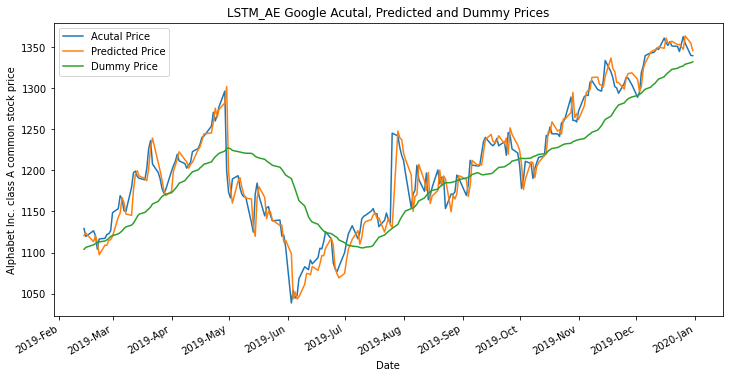

In [14]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

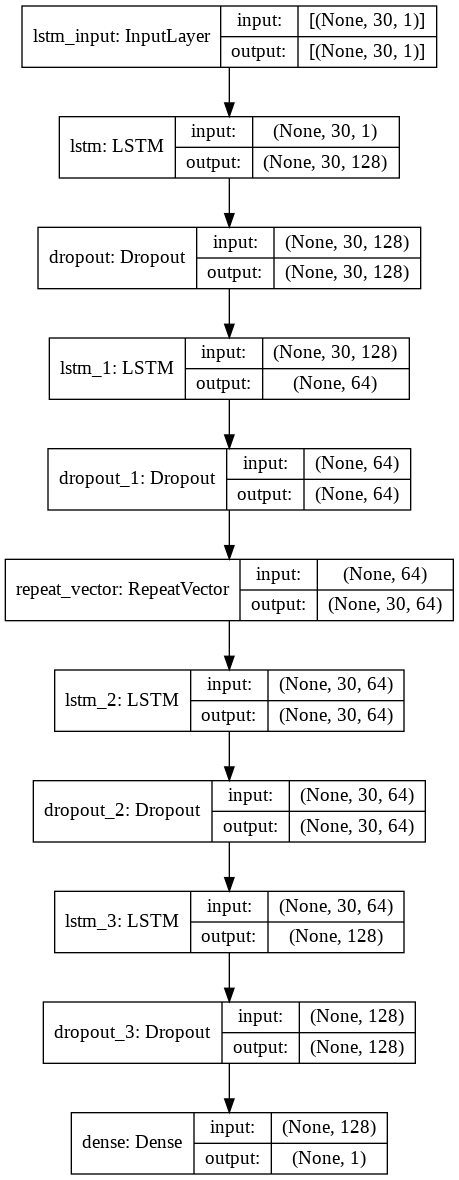

In [15]:
plot_model(model, show_shapes=True, expand_nested=True)

In [16]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0030887373508174114
RMSE:  0.05557641002095594
MAE:  0.03765626133236019
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [17]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Google/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Google/assets
